In [1]:
import qutip as qt
import numpy as np

# Tracking info of simulations 
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec

In [2]:
import model_building as md
import Hamiltonian as Ham
import dynamics as dyn
import data_handling as dh
import plots as plots


In [3]:
#Parameters

N=10
lmd = 0.02272
J = 0.5
state_dictionary = {"001":1}
state_dictionary = {"1":1}


ti = 0
tf = 150

Nsteps = 500

In [4]:

initial_state = md.crate_domain_wall_state(state_dictionary, register='Alice')
final_state   = md.crate_domain_wall_state(state_dictionary, register='Bob')

initial_chain = md.initialize_general_system(N, initial_state, register='Alice')
final_chain   = md.initialize_general_system(N, final_state, register='Bob')

In [5]:
#Create Hamiltonians
register_size = len(initial_state.dims[0])


H_transport = Ham.Hamiltonian(system_size = N,
                     mode = "forward",
                     lambda_factor = lmd,
                     global_J = J
                     )
H_reset     = Ham.Hamiltonian(system_size = N,
                     mode = "backward",
                     lambda_factor = lmd,
                     register_size = register_size,
                     global_J = J
                     )

In [6]:
#Algorithm

total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_chain, final_chain, H_transport, H_reset, ti, tf, Nsteps, AutoSwitch=True)

/Users/omichel/Desktop/qilimanjaro/projects/quantum_transport/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 514/514 [00:00<00:00, 4776.42it/s]


In [7]:
f_filename = dh.create_data_filename(N, J, lmd, state_dictionary, base_name='fidelity')
z_filename = dh.create_data_filename(N, J, lmd, state_dictionary, base_name='z_expectation')

f_data_directory = 'data_files/fidelity/'
z_data_directory = 'data_files/z_expectation/'

f_plot_directory = 'figures/fidelity/'
z_plot_directory = 'figures/z_expectation/' 


In [8]:
dh.save_numpy_array(total_full_fidelity, f'{f_data_directory}{f_filename}')
dh.save_numpy_array(magnetizations, f'{z_data_directory}{z_filename}')

In [ ]:
plots.plot_test_fidelity(total_full_fidelity, N, f'{f_plot_directory}{f_filename}')

In [ ]:
plots.plot_test_z_expectations(magnetizations, N, f'{z_plot_directory}{z_filename}')

## J vs lambda study

In [ ]:
def initialize_system(state_dictionary, N, lmd, J):
    initial_state = md.crate_domain_wall_state(state_dictionary, register='Alice')
    final_state   = md.crate_domain_wall_state(state_dictionary, register='Bob')

    initial_chain = md.initialize_general_system(N, initial_state, register='Alice')
    final_chain   = md.initialize_general_system(N, final_state, register='Bob')

    register_size = len(initial_state.dims[0])
    
    return initial_chain, final_chain, register_size

def build_hamiltonians(N, lmd, J, reg_size):

    H_transport = Ham.Hamiltonian(system_size = N,
                        mode = "forward",
                        lambda_factor = lmd,
                        global_J = J
                        )
    H_reset     = Ham.Hamiltonian(system_size = N,
                        mode = "backward",
                        lambda_factor = lmd,
                        register_size = reg_size,
                        global_J = J
                        )
    
    return H_transport, H_reset

In [13]:
#Constant simulation parameters
N = 10
lmd = 0.02272
ti = 0
tf = 150
step_number = 500

ratios = range(1,21) # will be used to calculate J accordingly


# Generate initial and target statess
state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}
# state_dictionary = {"111":1, "000":1}

initial_system, final_system, register_size = initialize_system(state_dictionary, N, lmd, J)
maximum_fidelities = []

for ratio in ratios:
    print(ratio)
    J = ratio*lmd
    H_transport, H_reset = build_hamiltonians(N, lmd, J, register_size)
    total_full_fidelity, magnetizations = dyn.TwoStepAlgorithm(initial_chain, final_chain, H_transport, H_reset, ti, tf, Nsteps, AutoSwitch=True)
    maximum_fidelities.append(max(total_full_fidelity))

1


100%|██████████| 548/548 [00:00<00:00, 21438.23it/s]


2


100%|██████████| 557/557 [00:00<00:00, 18404.04it/s]

3



100%|██████████| 542/542 [00:00<00:00, 16634.44it/s]


4


100%|██████████| 529/529 [00:00<00:00, 14857.78it/s]


5


100%|██████████| 518/518 [00:00<00:00, 12705.70it/s]


6


100%|██████████| 516/516 [00:00<00:00, 12014.79it/s]


7


100%|██████████| 516/516 [00:00<00:00, 11178.23it/s]


8


100%|██████████| 515/515 [00:00<00:00, 10245.68it/s]


9


100%|██████████| 515/515 [00:00<00:00, 9207.29it/s]


10


100%|██████████| 515/515 [00:00<00:00, 8484.49it/s]


11


100%|██████████| 515/515 [00:00<00:00, 8077.28it/s]


12


100%|██████████| 515/515 [00:00<00:00, 7643.79it/s]


13


100%|██████████| 515/515 [00:00<00:00, 5307.16it/s]


14


100%|██████████| 515/515 [00:00<00:00, 6563.46it/s]


15


100%|██████████| 515/515 [00:00<00:00, 4925.20it/s]


16


100%|██████████| 515/515 [00:00<00:00, 4549.39it/s]


17


100%|██████████| 514/514 [00:00<00:00, 5866.65it/s]


18


100%|██████████| 514/514 [00:00<00:00, 5616.58it/s]


19


100%|██████████| 514/514 [00:00<00:00, 5696.48it/s]


20


100%|██████████| 514/514 [00:00<00:00, 5024.98it/s]


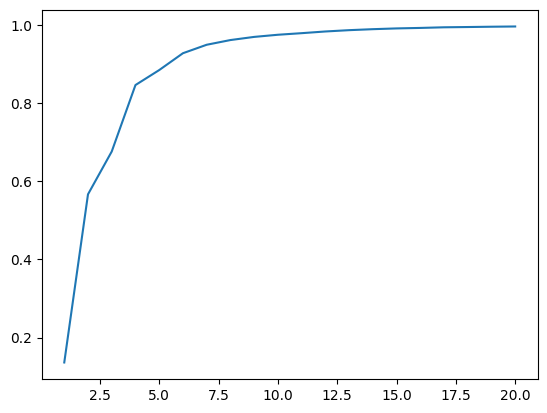

In [14]:
plt.plot(ratios, maximum_fidelities)
plt.show()